In [5]:
import matplotlib.pyplot as plt
import os
import tensorflow as tf


In [6]:
gpus = tf.config.experimental.list_physical_devices('GPU')

2024-06-12 15:17:46.523568: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-12 15:17:47.334236: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-12 15:17:47.334408: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [7]:
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [8]:
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)

In [9]:
pp = 'data/positive'
len(os.listdir(pp))

526

In [10]:
np = 'data/negative'
len(os.listdir(np))

13233

In [11]:
ap = 'data/anchor'
len(os.listdir(ap))

385

In [12]:
anchors = tf.data.Dataset.list_files(ap+'/*.jpg').take(350)
positives = tf.data.Dataset.list_files(pp+'/*.jpg').take(350)
negatives=tf.data.Dataset.list_files(np+'/*.jpg').take(350)

2024-06-12 15:17:47.415342: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-12 15:17:47.415708: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-12 15:17:47.415863: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [13]:
positivelabels = tf.data.Dataset.zip((anchors,positives,tf.data.Dataset.from_tensor_slices(tf.ones(350))))
negativelabels = tf.data.Dataset.zip((anchors,negatives,tf.data.Dataset.from_tensor_slices(tf.ones(350))))

In [14]:
Dataset = positivelabels.concatenate(negativelabels)


In [15]:
example = Dataset.as_numpy_iterator()


In [16]:
def preprocess(path):
    img = tf.io.read_file(path)
    img = tf.io.decode_jpeg(img)
    img = tf.image.resize(img,(105,105))
    img = img/255
    return img

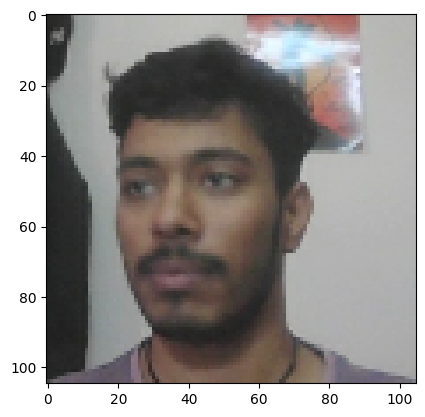

In [17]:
img,_,_ = example.next()
plt.imshow(preprocess(img))

In [18]:
def preprocess_label(img,img2,label):
    return(preprocess(img),preprocess(img2),label)

In [19]:
Dataset = Dataset.map(preprocess_label)

In [20]:
Dataset= Dataset.cache()


In [21]:
Dataset=Dataset.shuffle(buffer_size=1024)

In [22]:
train_data = Dataset.take(round(350*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [23]:
test_data  = Dataset.skip(round(350*.7))
test_data  = test_data.take(round(350*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [24]:
len(Dataset)

700

# Seasme

In [25]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer,Conv2D,MaxPooling2D,Input,Flatten,Dense

In [26]:
def net():
    #input layer
    inp = Input(shape=(105,105,3),name='input_layer')
    #first block
    L1  = Conv2D(64,(10,10),activation='relu')(inp)
    L2  = MaxPooling2D(64,(2,2),padding='same')(L1)

    #second block
    L3 = Conv2D(128,(7,7),activation='relu')(L2)
    L4 = MaxPooling2D(64,(2,2),padding='same')(L3)

    #third block
    L5 = Conv2D(128,(4,4),activation='relu')(L4)
    L6 = MaxPooling2D(64,(2,2),padding='same')(L5)
    # fourth block
    L7 = Conv2D(256,(4,4),activation='relu')(L6)
    f1 = Flatten()(L7)
    d1 = Dense(4096,activation='sigmoid')(f1)

    return Model(inputs=[inp],outputs=[d1],name='Net')
    

In [27]:
nnet =net()


In [28]:
def make_siamese():
    
    img = Input(shape=(105,105,3),name="img")
    check= Input(shape=(105,105,3),name='check')

    img_embd = nnet(img)
    check_embd = nnet(check)
    distance = tf.math.abs(img_embd-check_embd)

    classifier = Dense(1,activation='sigmoid')(distance)

    return Model(inputs=[img,check],outputs=[classifier],name ='SiameseNet')



In [29]:
siamese = make_siamese()

In [30]:
Loss = tf.losses.BinaryCrossentropy()
opt = tf.optimizers.Adam(1e-4)

In [31]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir,'ckpt')
checkpoint= tf.train.Checkpoint(opt=opt,siamese_model=siamese)

In [32]:
import numpy as np

In [33]:
@tf.function

def step(batch):

   
    with tf.GradientTape() as tape:

        X= batch[:2]
        Y=batch[2]
        
        yhat = siamese(X,training=True)
        loss = Loss(Y,yhat)

    grad = tape.gradient(loss, siamese.trainable_variables)

    opt.apply_gradients(zip(grad,siamese.trainable_variables))

    return loss

In [34]:
def train(data,Epoche):

    for epoch in range(1,Epoche+1):
        progbar = tf.keras.utils.Progbar(len(data))
        print("\nEpoche completed{}/{}".format(epoch,Epoche))
        for idx,batch in enumerate(data):
            print(len(batch))
            step(batch)
            progbar.update(idx+1)

        if epoch%10==0:
            checkpoint.save(file_prefix=checkpoint_prefix)

In [35]:
train(train_data,20)


Epoche completed1/20
3


2024-06-12 15:17:50.299168: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-06-12 15:17:50.805233: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-06-12 15:17:54.608854: I external/local_xla/xla/service/service.cc:168] XLA service 0x751a71fb7f00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-06-12 15:17:54.608873: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2024-06-12 15:17:54.642082: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1718185674.744623   14983 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 1/16 [>.............................] - ETA: 2:013
3
16/16 [==============================] - 16s 514ms/step

Epoche completed2/20
3
16/16 [==============================] - 7s 436ms/step

Epoche completed3/20
3
16/16 [==============================] - 6s 403ms/step

Epoche completed4/20
3
16/16 [==============================] - 6s 406ms/step

Epoche completed5/20
3
16/16 [==============================] - 6s 422ms/step

Epoche completed6/20
3
16/16 [==============================] - 6s 410ms/step

Epoche completed7/20
3
16/16 [==============================] - 6s 395ms/step

Epoche completed8/20
3
16/16 [==============================] - 6s 396ms/step

Epoche completed9/20
3
16/16 [==============================] - 6s 413ms/step

Epoche completed10/20
3
16/16 [==============================] - 6s 391ms/step


2024-06-12 15:19:01.586616: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 150994944 exceeds 10% of free system memory.
2024-06-12 15:19:01.641637: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 150994944 exceeds 10% of free system memory.
2024-06-12 15:19:01.732180: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 150994944 exceeds 10% of free system memory.



Epoche completed11/20
3
16/16 [==============================] - 6s 382ms/step

Epoche completed12/20
3
16/16 [==============================] - 6s 381ms/step

Epoche completed13/20
3
16/16 [==============================] - 6s 381ms/step

Epoche completed14/20
3
16/16 [==============================] - 6s 379ms/step

Epoche completed15/20
3
16/16 [==============================] - 6s 382ms/step

Epoche completed16/20
3
16/16 [==============================] - 6s 381ms/step

Epoche completed17/20
3
16/16 [==============================] - 6s 384ms/step

Epoche completed18/20
3
16/16 [==============================] - 6s 393ms/step

Epoche completed19/20
3
16/16 [==============================] - 6s 402ms/step

Epoche completed20/20
3
16/16 [==============================] - 6s 378ms/step


2024-06-12 15:20:02.410252: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 150994944 exceeds 10% of free system memory.
2024-06-12 15:20:02.465434: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 150994944 exceeds 10% of free system memory.


In [39]:
siamese.compile(optimizer='adam',loss='binary_crossentropy')

In [40]:
siamese.save('MY.h5')

/home/itachi/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Testing Model

In [37]:
import tensorflow as tf


In [41]:
from tensorflow.keras.models import Model

model = tf.keras.models.load_model('MY.h5')

In [60]:
it = test_data.as_numpy_iterator()

img,check,l = it.next()

yhat = model.predict([img,check])



1/1 [==============================] - 0s 20ms/step


In [61]:
l.shape

(16,)

In [62]:
yhat = yhat.reshape(-1)

yhat.shape


(16,)

In [63]:
from tensorflow.keras.metrics import Precision,Recall,Accuracy

accu =  Accuracy()
accu.update_state(l,yhat)
accu.result().numpy()

0.5625